# Fig 2c

The abundance of Pseudomonas

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "genus"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa=taxa)
tax_df = cf_analysis_lib.read_taxonomy(datadir, sequence_type, taxa)
df = tax_df.T

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


In [2]:
for c in df.columns:
    if 'pseudom' in c.lower():
        print(c)

Rhodopseudomonas
Pseudomethylobacillus
Pseudomaricurvus
Halopseudomonas
Pseudomonas
Thiopseudomonas
Pseudomarimonas


In [3]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

The mean for Pseudomonas is 20934.62682519509 and the median is 2721.3378860620664


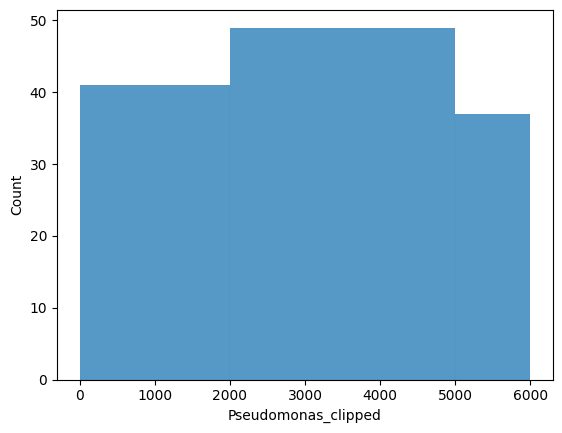

In [4]:
# Create some bins for the sizes
# Define the bins and labels
# Non zero mean is the mean of all the non zero values
genus = 'Pseudomonas'
mn = np.mean(df[df[genus] > 0][genus])
md = np.median(df[df[genus] > 0][genus])
print(f"The mean for {genus} is {mn} and the median is {md}", file=sys.stderr)


nonzeromean = np.median(df[df[genus] > 0][genus])
# bins = [-1, 0, nonzeromean/2, nonzeromean*2, float('inf')]  # Include -1 to capture 0 in 'small'
# bins = [-1, 200, 5000, 10000, float('inf')]
bins = [-1, 0, 2000, 5000, 6000]
labels = ['small', 'medium', 'large']
sizelist = [10, 100, 500, 1000]
marker_shapes = ['s', 'V', '^', 'o'] # see https://seaborn.pydata.org/tutorial/properties.html#marker

df[f"{genus}_clipped"] = np.where(df[genus] > 5000, 5500, df[genus])
sns.histplot(data=df[f"{genus}_clipped"], bins=bins)

# Create a new column 'size' based on the conditions
sizes = list(pd.cut(df['Pseudomonas'], bins=bins, labels=sizelist))
markers = list(pd.cut(df['Pseudomonas'], bins=bins, labels=marker_shapes))

Pseudomonas detected by MGI sequencing coloured whether positive - present
Median number of Pseudomonas sequences: 2721


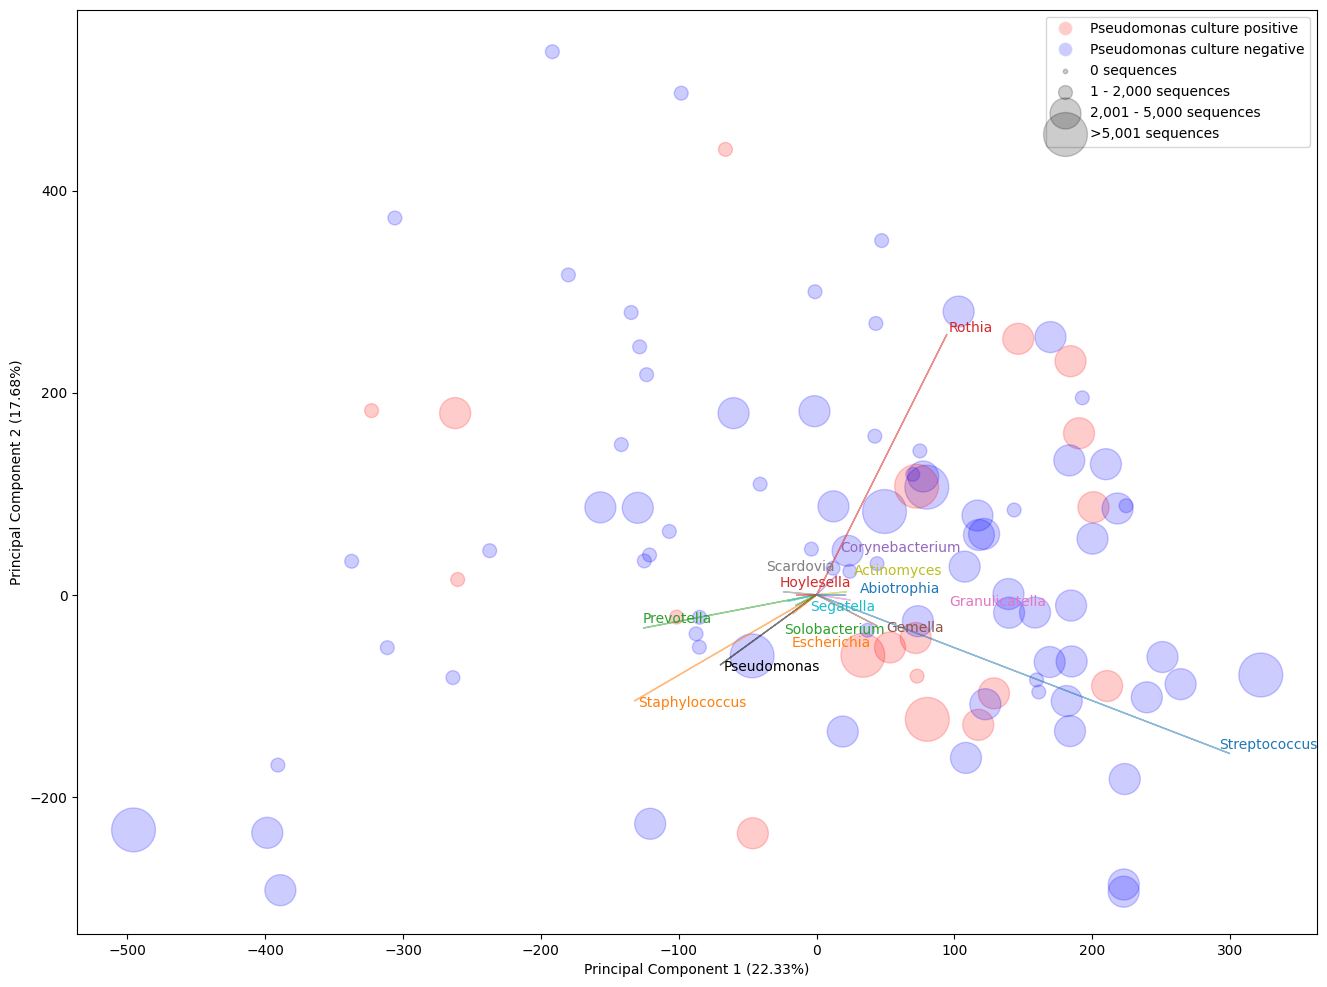

In [5]:
# Map colors based on the metadata column
colours = np.where(metadata['CS_Pseudomonas aeruginosa'] == 1, 'red', 'blue')

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
# plt.title('Pseudomonas detected by MGI sequencing coloured whether positive - present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
print(f"Pseudomonas detected by MGI sequencing coloured whether positive - present\nMedian number of {genus} sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.2f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    if top_loadings_df.index[i] == 'Pseudomonas':
        found_pseudomonas = True
        c = 'black'
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

if not found_pseudomonas:
    # specifically add Pseudomonas
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))


    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='red', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='blue', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]+1:,.0f} - {bins[2]:,.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]+1:,.0f} - {bins[3]:,.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]+1:,.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


plt.savefig('final_images/fig2c.png', dpi=300)
plt.savefig('final_images/fig2c.svg')
# Show the plot
plt.show()